In [4]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt

import os

In [5]:
# Project file variables and operations
save_dir = "diabetic_neuropathy_random_samples"
os.makedirs(save_dir, exist_ok=True)

## Loading the Original Dataset

In [6]:
random_state = 42
df = pd.read_csv("data_export_icin.csv", delimiter=';')
df.dropna(axis=0, inplace=True)


df.rename(columns={'diabetic_nueropathy': 'diabetic_neuropathy'}, inplace=True)
target_col = "diabetic_neuropathy"

variables = [
    "HbA1c", "sex", "age", "Malign_neoplasms", "Thyroid_dis", "anemia",
    "vitamin_deficiency", "lipoprotein_met_dis", "endocrine_other", "depression",
    "anxiety_dis", "retinopathy", "eye_other", "hypertension_i10",
    "cerebrovascular", "other_circulatory", "gastro_oes_reflux", "digestive_sys_dis",
    "musculoskeletal_dis", "kidney_failure", "other_digestive", "lipid_modifying", "gynecologic_drugs",
    "musculosceletal_drugs", "antiparkinson", "antipsychotics", "pshycoanaleptics", "respiratory_sys_drugs", "eye_ear_drugs",
    "dapagliflozin", "eksenatid", "gliklazid", "glimepirid", "insulin_aspart", "insulin_detemir",
    "insulin_glarjin", "insulin_glusilin", "insulin_lispro", "linagliptin", "metformin_hcl", "nateglinid",
    "pioglitazon_hcl", "repaglinide","saksagliptin", "sitagliptin", "vildagliptin", "diabetic_neuropathy"]


df = df[variables]

print(df.diabetic_neuropathy.value_counts())

diabetic_neuropathy
0    64249
1    13475
Name: count, dtype: int64


## Calculating Feature Importances

Metric: Area Under Curve (AUC)

### RF

In [7]:
# -----------------------------
# LOAD ORIGINAL DATA
# -----------------------------
X_full = df.drop(columns=[target_col])
y_full = df[target_col]

# -----------------------------
# TRAIN/TEST SPLIT ON ORIGINAL DATA
# -----------------------------
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full, y_full, test_size=0.3, stratify=y_full, random_state=random_state
)

rf = RandomForestClassifier(max_depth=3, random_state=random_state)
rf_model = rf.fit(X_train_full, y_train_full)

y_train_pred_prob = rf_model.predict_proba(X_train_full)[:, 1]
y_test_pred_prob = rf_model.predict_proba(X_test_full)[:, 1]

train_auc = roc_auc_score(y_train_full, y_train_pred_prob)
test_auc = roc_auc_score(y_test_full, y_test_pred_prob)

print(f"Original Model AUCs:\nTrain AUC: {train_auc:.4f}\nTest AUC: {test_auc:.4f}")

Original Model AUCs:
Train AUC: 0.7578
Test AUC: 0.7585


### Feature Importances

In [8]:
# -----------------------------
# DETERMINE FEATURE IMPORTANCE ON ORIGINAL DATA
# -----------------------------

importances = pd.Series(rf_model.feature_importances_, index=X_train_full.columns)
importances_sorted = importances.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, max(6, 0.35 * len(importances_sorted))))
ax.barh(importances_sorted.index, importances_sorted.values)
ax.invert_yaxis()  # highest importance at top
ax.set_xlabel("Gini Importance")
ax.set_ylabel("Feature")
ax.set_title("Feature Importances")
plt.tight_layout()

# Saving the plot
fi_png_path = os.path.join(save_dir, "feature_importances.png")
fig.savefig(fi_png_path, dpi=300)
plt.close(fig)

print(f"Saved feature importance plot to: {fi_png_path}")

Saved feature importance plot to: diabetic_neuropathy_random_samples\feature_importances.png


In [10]:
importances_sorted

other_digestive          0.308337
insulin_glarjin          0.124235
insulin_aspart           0.082006
pshycoanaleptics         0.075556
HbA1c                    0.062897
hypertension_i10         0.056591
musculoskeletal_dis      0.042973
retinopathy              0.041978
age                      0.030462
lipoprotein_met_dis      0.025935
musculosceletal_drugs    0.021713
insulin_glusilin         0.017873
cerebrovascular          0.017526
other_circulatory        0.011161
depression               0.010965
vitamin_deficiency       0.010364
eye_ear_drugs            0.008890
lipid_modifying          0.007203
insulin_lispro           0.007167
digestive_sys_dis        0.005348
gastro_oes_reflux        0.004397
insulin_detemir          0.003742
eye_other                0.003696
antiparkinson            0.003366
metformin_hcl            0.003276
linagliptin              0.003178
anxiety_dis              0.002959
pioglitazon_hcl          0.001560
anemia                   0.001404
gliklazid     

In [ ]:
# Saving the feature importances
importances_sorted.to_csv(os.path.join(save_dir, "feature_importances.csv"), index=True)

## Generating Subsets Based on Increasing Sample Sizes and Features

In [11]:
# -----------------------------
# PARAMETERS
# -----------------------------
sample_sizes = [100, 300, 500, 1000, 3000, 5000, 7000, 10000, 15000, 20000, 25000]
feature_numbers = [3, 5, 10, 20, 30, 40, 46]
n_repeats = 10

np.random.seed(42)

# -----------------------------
# PREPARE CLASS-SPECIFIC DATAFRAMES (for balanced sampling)
# -----------------------------
df_pos = df[df[target_col] == 1]
df_neg = df[df[target_col] == 0]

n_features_total = X_full.shape[1]

# -----------------------------
# CREATE DATASETS (BALANCED 50/50)
# -----------------------------
for n in sample_sizes:
    half = n // 2  # number of samples per class

    for repeat in range(1, n_repeats + 1):
        seed_pos = np.random.randint(0, 1_000_000)
        seed_neg = np.random.randint(0, 1_000_000)
        shuffle_seed = np.random.randint(0, 1_000_000)

        sampled_pos = df_pos.sample(n=half, random_state=seed_pos, replace=False)
        sampled_neg = df_neg.sample(n=half, random_state=seed_neg, replace=False)

        sampled_df = pd.concat([sampled_pos, sampled_neg], axis=0) \
                       .sample(frac=1, random_state=shuffle_seed) \
                       .reset_index(drop=True)

        for k in feature_numbers:
            if k >= n_features_total:
                features_to_use = X_full.columns.tolist()
                k_label = n_features_total
            else:
                features_to_use = importances_sorted.index[:k].tolist()
                k_label = k

            dataset_to_save = sampled_df[features_to_use + [target_col]]
            filename = f"{save_dir}/dataset_n{n}_features{k_label}_repeat{repeat}.csv"
            dataset_to_save.to_csv(filename, index=False)
            print(f"Saved: n={n}, features={k_label}, repeat={repeat}")

Saved: n=100, features=3, repeat=1
Saved: n=100, features=5, repeat=1
Saved: n=100, features=10, repeat=1
Saved: n=100, features=20, repeat=1
Saved: n=100, features=30, repeat=1
Saved: n=100, features=40, repeat=1
Saved: n=100, features=46, repeat=1
Saved: n=100, features=3, repeat=2
Saved: n=100, features=5, repeat=2
Saved: n=100, features=10, repeat=2
Saved: n=100, features=20, repeat=2
Saved: n=100, features=30, repeat=2
Saved: n=100, features=40, repeat=2
Saved: n=100, features=46, repeat=2
Saved: n=100, features=3, repeat=3
Saved: n=100, features=5, repeat=3
Saved: n=100, features=10, repeat=3
Saved: n=100, features=20, repeat=3
Saved: n=100, features=30, repeat=3
Saved: n=100, features=40, repeat=3
Saved: n=100, features=46, repeat=3
Saved: n=100, features=3, repeat=4
Saved: n=100, features=5, repeat=4
Saved: n=100, features=10, repeat=4
Saved: n=100, features=20, repeat=4
Saved: n=100, features=30, repeat=4
Saved: n=100, features=40, repeat=4
Saved: n=100, features=46, repeat=4


## Loading Previously Generated Subsets, Evaluating RF Performance and Saving the Results

In [12]:
# ---------------------------------
# Run
# ---------------------------------
results = []

for n in sample_sizes:
    for k in feature_numbers:
        auc_train_list, auc_test_list = [], []

        for repeat in range(1, n_repeats + 1):
            filename = f"{save_dir}/dataset_n{n}_features{k}_repeat{repeat}.csv"
            df = pd.read_csv(filename)

            X = df.drop(columns=[target_col])
            y = df[target_col]

            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, stratify=y, random_state=random_state + repeat
            )

            rf = RandomForestClassifier(max_depth=3, random_state=random_state + repeat)
            rf.fit(X_train, y_train)

            y_train_prob = rf.predict_proba(X_train)[:, 1]
            y_test_prob = rf.predict_proba(X_test)[:, 1]

            auc_train_list.append(roc_auc_score(y_train, y_train_prob))
            auc_test_list.append(roc_auc_score(y_test, y_test_prob))

        mean_auc_train = float(np.mean(auc_train_list))
        mean_auc_test = float(np.mean(auc_test_list))

        results.append({
            "sample_size": n,
            "feature_number": k,
            "mean_auc_train": mean_auc_train,
            "mean_auc_test": mean_auc_test
        })

        print(f"n={n:>6}, features={k:>3} | Train AUC={mean_auc_train:.4f}  Test AUC={mean_auc_test:.4f}")

results_df = pd.DataFrame(results)
results_df.to_csv("results.csv", index=False)
print("Saved results.csv")

n=   100, features=  3 | Train AUC=0.8033  Test AUC=0.6091
n=   100, features=  5 | Train AUC=0.8911  Test AUC=0.6396
n=   100, features= 10 | Train AUC=0.9319  Test AUC=0.6591
n=   100, features= 20 | Train AUC=0.9541  Test AUC=0.6391
n=   100, features= 30 | Train AUC=0.9681  Test AUC=0.6453
n=   100, features= 40 | Train AUC=0.9759  Test AUC=0.6538
n=   100, features= 46 | Train AUC=0.9787  Test AUC=0.6307
n=   300, features=  3 | Train AUC=0.7651  Test AUC=0.6977
n=   300, features=  5 | Train AUC=0.8234  Test AUC=0.7296
n=   300, features= 10 | Train AUC=0.8517  Test AUC=0.7421
n=   300, features= 20 | Train AUC=0.8626  Test AUC=0.7412
n=   300, features= 30 | Train AUC=0.8848  Test AUC=0.7383
n=   300, features= 40 | Train AUC=0.8968  Test AUC=0.7320
n=   300, features= 46 | Train AUC=0.9021  Test AUC=0.7426
n=   500, features=  3 | Train AUC=0.7620  Test AUC=0.7153
n=   500, features=  5 | Train AUC=0.7998  Test AUC=0.7329
n=   500, features= 10 | Train AUC=0.8230  Test AUC=0.74

## Visualizing and Analyzing the Results

In [13]:
# Loading the results
results_df = pd.read_csv("results.csv")
results_df["sample_size"] = pd.to_numeric(results_df["sample_size"], errors="coerce")

### Test Set

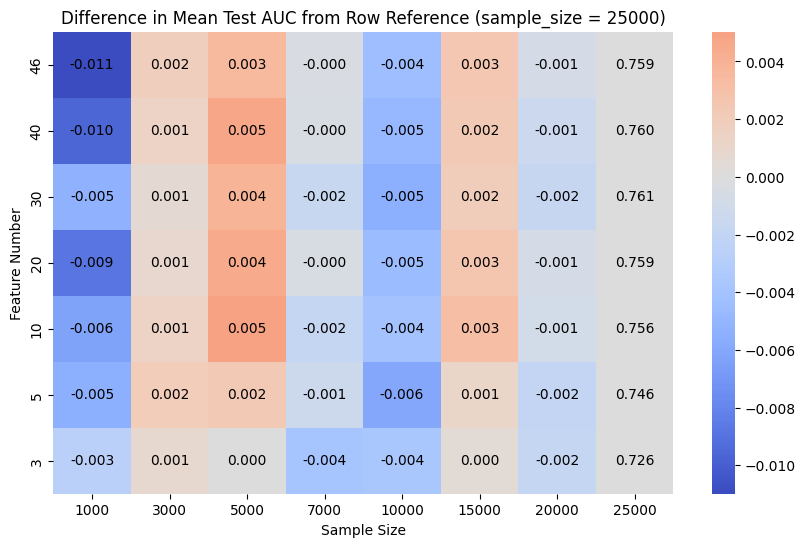

In [14]:
pivot_df = results_df.pivot(index="feature_number",
                            columns="sample_size",
                            values="mean_auc_test").sort_index(ascending=False)

# Small sample sizes are excluded
cols_to_exclude = [100, 300, 500]
pivot_df = pivot_df.drop(columns=[c for c in cols_to_exclude if c in pivot_df.columns])

# Sorting the columns
pivot_df = pivot_df.reindex(sorted(pivot_df.columns), axis=1)

# Row-wise reference
ref_col = 25000  # Reference column
diff_df = pivot_df.sub(pivot_df[ref_col], axis=0)

# Annotating reference cells with the actual AUC instead of 0
annot_df = diff_df.copy()
annot_df[ref_col] = pivot_df[ref_col]  # Writing true AUC values into the ref column

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(
    diff_df,
    annot=annot_df,          # show differences everywhere, but AUC in ref column
    cmap="coolwarm",
    center=0,
    fmt=".3f",
    annot_kws={"color": "black"}
)
plt.title("Difference in Mean Test AUC from Row Reference (sample_size = 25000)")
plt.ylabel("Feature Number")
plt.xlabel("Sample Size")
plt.savefig('test_rowref.png', bbox_inches='tight')
plt.show()

### Training Set

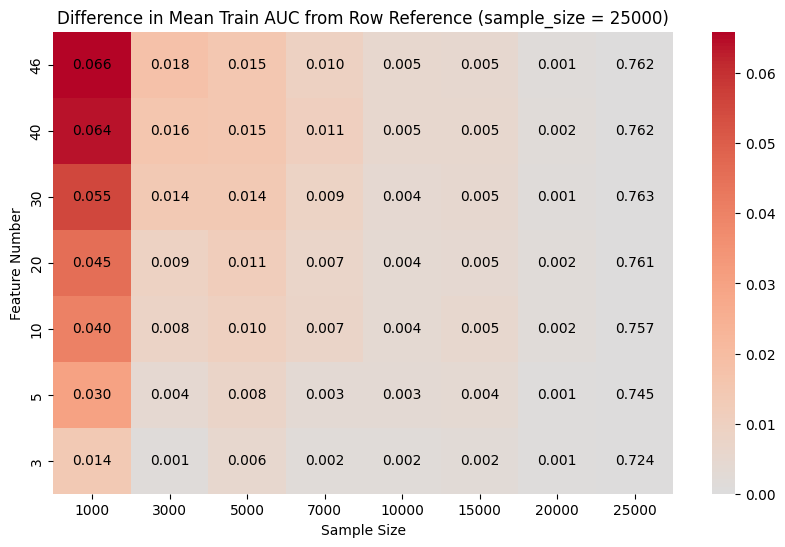

In [15]:
# Loading the results
results_df = pd.read_csv("results.csv")
results_df["sample_size"] = pd.to_numeric(results_df["sample_size"], errors="coerce")

pivot_df = results_df.pivot(index="feature_number",
                            columns="sample_size",
                            values="mean_auc_train").sort_index(ascending=False)

# Small sample sizes are excluded
cols_to_exclude = [100, 300, 500]
pivot_df = pivot_df.drop(columns=[c for c in cols_to_exclude if c in pivot_df.columns])

# Sorting the columns
pivot_df = pivot_df.reindex(sorted(pivot_df.columns), axis=1)

# Row-wise reference
ref_col = 25000  # Reference column
diff_df = pivot_df.sub(pivot_df[ref_col], axis=0)

# Annotating reference cells with the actual AUC instead of 0
annot_df = diff_df.copy()
annot_df[ref_col] = pivot_df[ref_col]  # Writing true AUC values into the ref column

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(
    diff_df,
    annot=annot_df,          # show differences everywhere, but AUC in ref column
    cmap="coolwarm",
    center=0,
    fmt=".3f",
    annot_kws={"color": "black"}
)
plt.title("Difference in Mean Train AUC from Row Reference (sample_size = 25000)")
plt.ylabel("Feature Number")
plt.xlabel("Sample Size")
plt.savefig('train_rowref.png', bbox_inches='tight')
plt.show()